# Lab: RNNs for Time Series Prediction


------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this notebook, you will deploy a simple probabilistic model using a RNN to infer the probability distribution of a time-series. Given a set of signals  $\mathcal{D}=\{X^1,X^2,\ldots,X^N\}$ where $$X^i = [X_0^i,X_1^i,\ldots,X_T^i]$$
is the $i$-th signal, we will train a probabilistic model of the form
$$p(X|X_0) = \prod_{t=1}^T p(X_t|\mathbf{X}_{0:t-1})$$
where $\mathbf{X}_{0:t-1}=[X_0,X_1,\ldots,X_{t-1}]$ and every conditional factor $p(X_t|\mathbf{X}_{0:t-1})$ corresponds to a Gaussian distribution with mean and variance obtained **from the state of a RNN** with input $X_{t-1}$. The RNN state $\mathbf{h}_{t-1}$ is a projection of the the signal up to time $t-2$, i.e, $\mathbf{X}_{0:t-2}$:

$$
p(X_t|X_{t-1},\mathbf{X}_{0:t-2}) = \mathcal{N}\left(f_{RNN}(X_{t-1},\mathbf{h}_{t-1}),\sigma^2+g_{RNN}(X_{t-1},\mathbf{h}_{t-1})\right),
$$


where $\sigma^2$ is a constant basal variance that we treat as an hiper-parameter. During training, we approximate the expected loss at time $t$
$$\mathcal{L}_t=\mathbb{E}_{\hat{X}_t\sim p(X_t|X_{t-1},\mathbf{X}_{0:t-2})}[(X_t-\hat{X}_t)^2]$$
using a single sample of $p(X_t|X_{t-1},\mathbf{X}_{0:t-2})$. The global loss is accumulated during the whole signal length:

$$\mathcal{L} = \frac{1}{T}\sum_{t=1}^T \mathcal{L}_t$$

**Important:** during training, we **feed the RNN with the true values of the signal**. Namely, at each time point $\mathbf{h}_{t-1}$ is calculated with the true values of the signal. This strategy is known as **teaching forcing**.




In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!


## Part I. Create a synthetic database

We will generate $N$ target signals of length $T$ time steps. We generate each signal as one realization of the following autoregressive model
\begin{align}
X_{t}=c+\sum_{i=1}^{p} \varphi_{i} X_{t-i}+\varepsilon_{t}
\end{align}
where $\varepsilon_{t}\sim \mathcal{N}(0,\sigma_{\epsilon})$ and $c$,$\varphi_{i}$ $i=1,\ldots,p$ are real coefficients.


An ARMA (Autoregressive Moving Average) process is a model for time series data that combines two components:

1. **Autoregressive (AR) Component**: This part models the series based on its own past values. For example, in an AR(1) process, the current value \( X_t \) depends linearly on the previous value \( X_{t-1} \). An AR process of order \( p \) can be written as:
   $$
   X_t = \varphi_1 X_{t-1} + \varphi_2 X_{t-2} + \dots + \varphi_p X_{t-p} + \epsilon_t
   $$
   where $\epsilon_t$ is white noise (random error).

2. **Moving Average (MA) Component**: This part models the series based on past error terms (white noise terms). In an MA(1) process, the current value depends on the previous error term  $\epsilon_{t-1}$. An MA process of order \( q \) is written as:
   $$
   X_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}
   $$

An **ARMA(p, q)** model combines both components, allowing the series to depend on both past values and past errors:
$$
X_t = \varphi_1 X_{t-1} + \dots + \varphi_p X_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q}
$$

ARMA models are widely used because they can effectively model many types of stationary time series data.


In [2]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 17.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 8.3 MB/s eta 0:00:00


We use the library [statsmodel](https://www.statsmodels.org/stable/index.html) to generate the above signals ...

In [3]:
# We use statsmodels

import statsmodels.api as sm

maparams = []
arparams = np.array([.35, .35,0.75,-0.65,-0.15,0.01]) #phi coefficients

ar = np.r_[1, -arparams]
ma = np.r_[1, maparams]
model = sm.tsa.ArmaProcess(ar, ma) #We use c=0 y and unit variance for the noise

In [4]:
N = 1000 

T = 300

X = model.generate_sample((N,T),axis=1,burnin=50) #We ignore the 50 first samples of every signal

In [5]:
X.shape

(1000, 300)

Given the set of signals, let's create the targets just like the original offset signals:


In [6]:
Y = X[:,1:] 
X = X[:,:-1] 

T -=1

Lets plot one of the signals versus the *target*, which is the same signal but shifted to the right ...

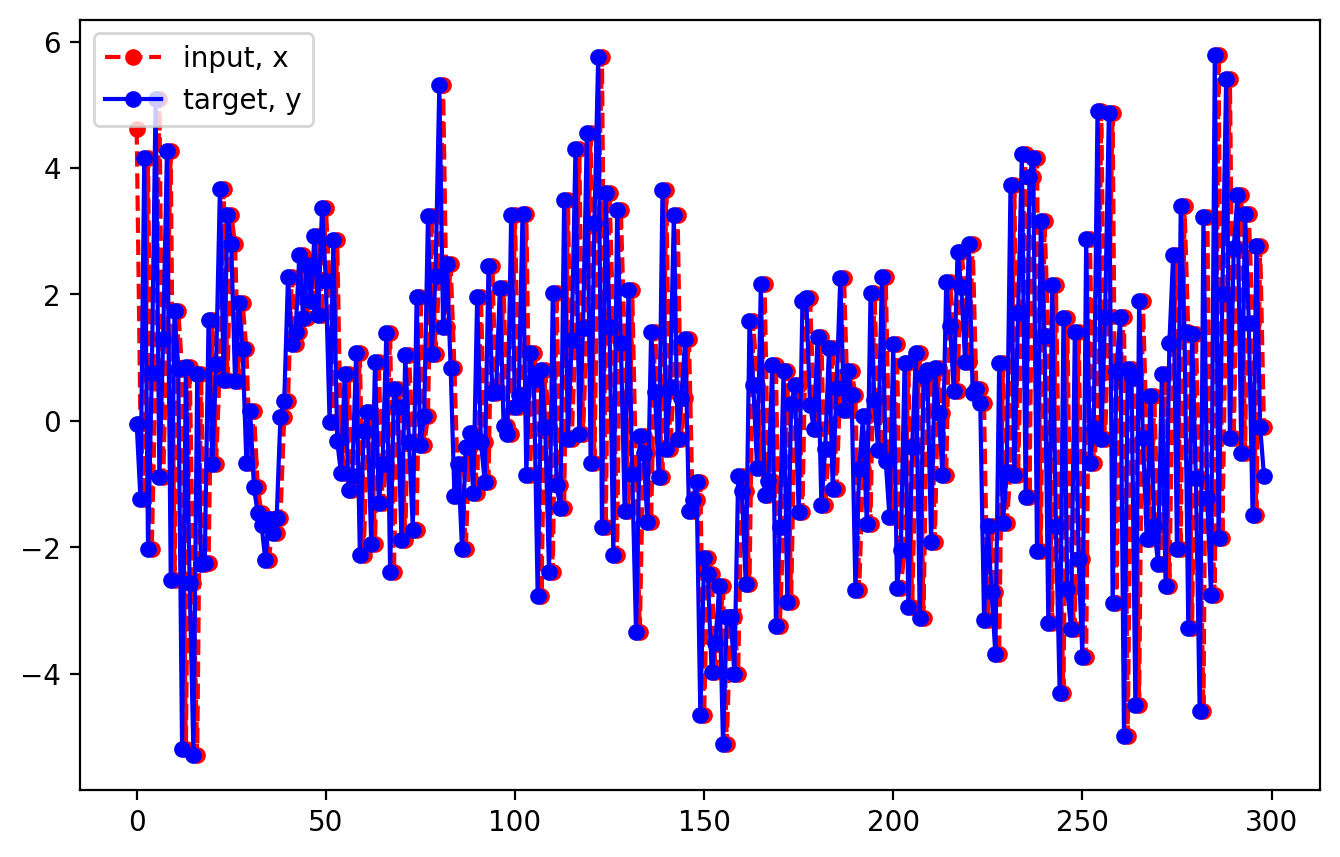

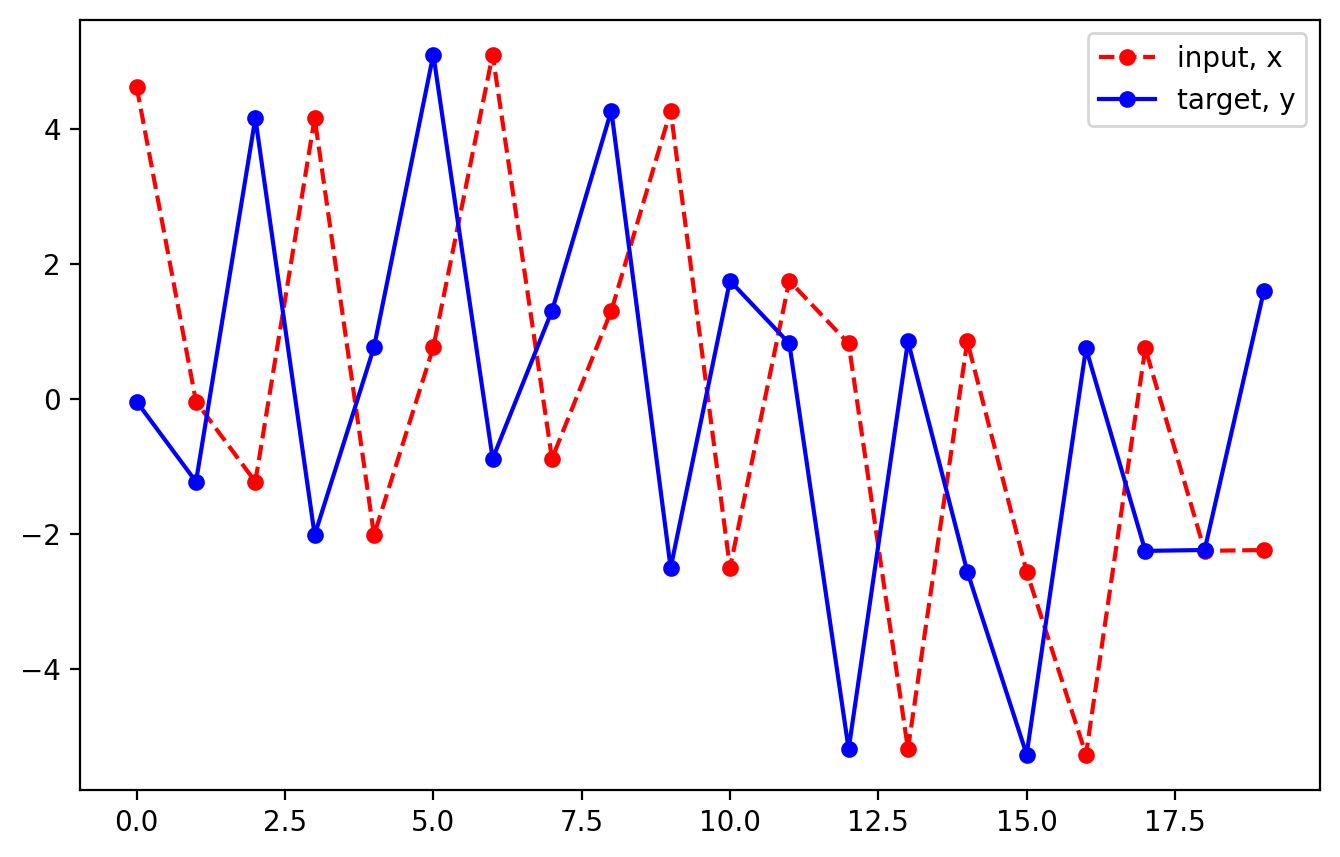

In [7]:
# Plot the signal 
plt.figure(figsize=(8,5))
plt.plot(np.arange(T), X[1,:T], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(T), Y[1,:T], 'b.-', label='target, y',ms=10) # y

plt.legend(loc='best')

# Plot the signal (20 first steps)
plt.figure(figsize=(8,5))
plt.plot(np.arange(20), X[1,:20], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(20), Y[1,:20], 'b.-', label='target, y',ms=10) # y

plt.legend(loc='best')

## Part II. Define RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, which takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the dimension of the RNN output and the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a **stacked RNN** 


This is an example of a stacked RNN

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*sBfgsRRLyknLfca7.jpg" width="40%"> 


If you take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn), you will see that `nn.RNN` only provides the actual computation of the hidden states along time
$$
h_{t} = g \left(W_{i h} x_{t} + b_{i h} + W_{h h} h_{(t-1)} + b_{h h}\right)
$$

Then we'll add a last, fully-connected layer to get the output size that we want. For simplicity, **the input to this dense layer is the state $h_t$ of the RNN**.

You have to pay special attention to the dimensions of the input/output tensors of the RNN. **Check the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn)**.




The following class implements a class where 
- An input signal of dimension `input_size` is processed by a RNN. As a result, we obtain a sequence of states $\mathbf{h}_{t}$, from $t=1$ to $t=T$.
- We process each state with **two linear layers** to estimate the mean and variance of the output signal at time $t$ from $\mathbf{h}_{t}$. Both the mean and variance are of dimension (`output_size`). 
- The `forward` method also return a sample of the estimated signal.


> **Exercise**: complete the following code. Understand all steps, particularly those in the `forward` method.

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,sigma):
        
        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size

        self.output_size = output_size
        
        self.sigma = torch.Tensor(np.array(sigma))

        # define an RNN with specified parameters
        # batch_first=True means that the first dimension of the input will be the batch_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, 
                          nonlinearity='relu',batch_first=True)
        
        # One linear layer to estimate mean
        self.fc1 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE
        # One linear layer to estimate log-variance
        self.fc2 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE

    def forward(self, x, h0=None):
        
        '''
        About the shape of the different tensors ...:
        
        - Input signal x has shape (batch_size, seq_length, input_size)
        - The initialization of the RNN hidden state h0 has shape (n_layers, batch_size, hidden_dim).
          If None value is used, internally it is initialized to zeros.
        - The RNN output (batch_size, seq_length, hidden_size). This output is the RNN state along time  

        '''
        
        batch_size = x.size(0) # Number of signals N
        seq_length = x.size(1) # T
        
        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state (we will use it for forecasting)
        r_out, hidden = self.rnn(x, h0)
        
        # shape r_out to be (seq_length, hidden_dim) #UNDERSTANDING THIS POINT IS IMPORTANT!!        
        r_out = r_out.reshape(-1, self.hidden_dim) 
        
        # We compute the mean
        mean = self.fc1(r_out)
        
        # We compute the variance
        variance = torch.exp(self.fc2(r_out))+torch.ones(mean.shape)*self.sigma

        # We generate noise of the adecuate variance
        noise = torch.randn_like(mean)*torch.sqrt(variance)
        
        sample = mean+noise
        
        # reshape back to temporal structure
        sample = sample.reshape([-1,seq_length,int(self.output_size)])
        mean = mean.reshape([-1,seq_length,int(self.output_size)])
        variance = variance.reshape([-1,seq_length,int(self.output_size)])
        
        return mean, variance, hidden, sample


> **Exercise:** Instantiate the object RNN with the right parameters for our problem. Use `hidden_dim=32`, `n_layers=1` and `sigma=1`

In [9]:
# test that dimensions are as expected
my_rnn = RNN(input_size=1, output_size=1, hidden_dim=32, n_layers=1,sigma=1.0)

In the following code, we compute the model output using the `forward` method. Note that we use an all zero initial state.

> **Exercise**: Using the `forward` method, compare the signal predicted mean against the true value during the first 20 time instants for one of the signals. Note that the parameters of the RNN have not been trained...



La dimensión del estado es
torch.Size([1, 1000, 32])

La dimensión de predicción es
torch.Size([1000, 299, 1])


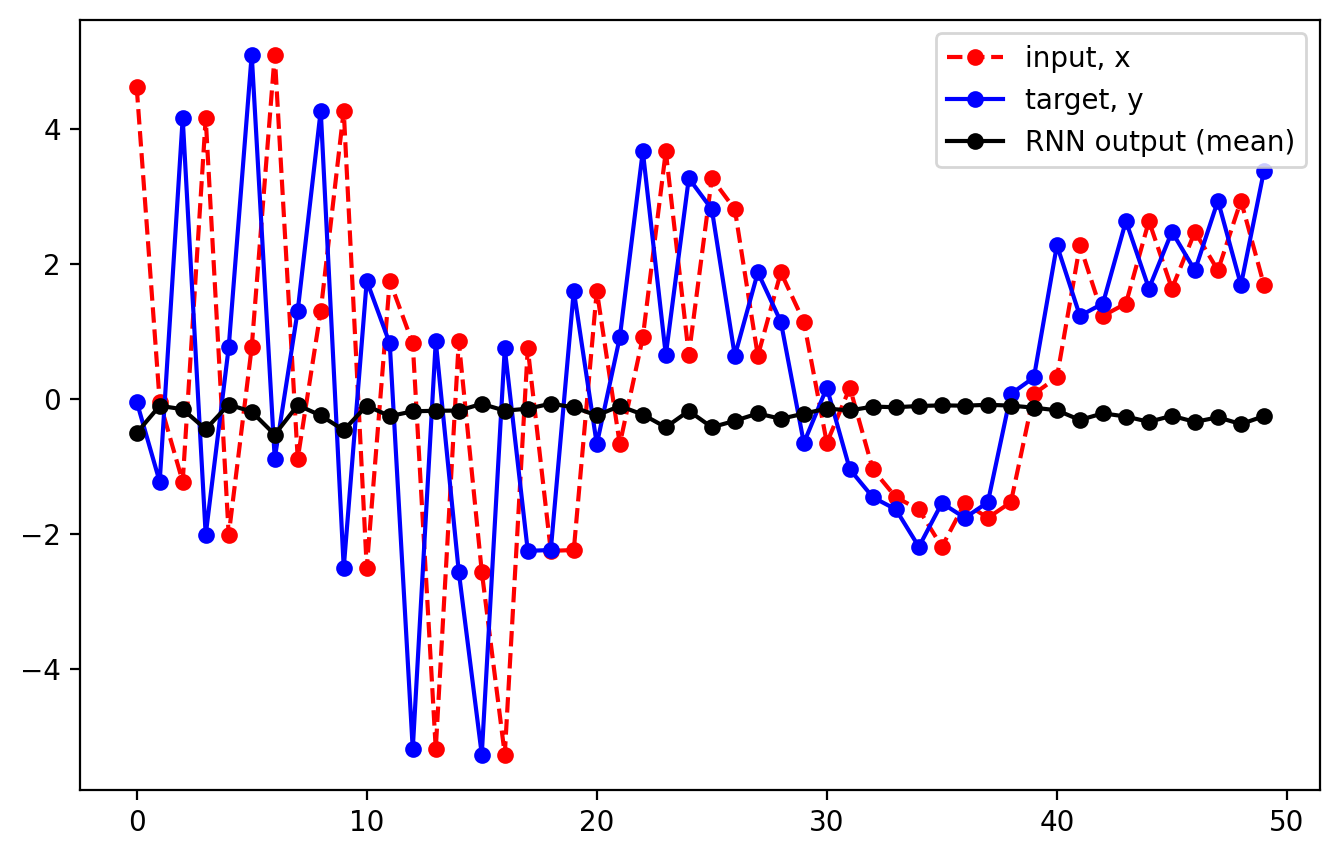

In [10]:
X_in = torch.Tensor(X).view([-1,T,1])

mean,var,h,sample = my_rnn.forward(X_in) # YOUR CODE HERE

print(f'La dimensión del estado es')
print(h.shape)

print(f'\nLa dimensión de predicción es')
print(mean.shape)

output_no_train = mean.detach().numpy().reshape([N,-1])

# Instante incial para la representación
t0 = 0

# Instante final
tf = 50

signal = 1 # Ejemplo de señal

# Plot the first training signal and the target
plt.figure(figsize=(8,5))
plt.plot(np.arange(t0,tf,1), X[signal,t0:tf], 'r.--', label='input, x',ms=10) 
plt.plot(np.arange(t0,tf,1), Y[signal,t0:tf], 'b.-', label='target, y',ms=10) 
plt.plot(np.arange(t0,tf,1), output_no_train[signal,t0:tf], 'k.-', label='RNN output (mean)',ms=10) 
plt.legend()




> **Exercise:** Complete the code for the following class, which extends `RNN` to include a training method. 

Note that there is no mini-batch, we process all signals for every SGD iteration. You are free to the mini-batch training functionality. 
Another novelty, typically associated with RNNs, is limiting the absolute value of the gradients (*gradient clipping*) to a preset value (2.0 in the code). When processing very long sequences, the product of terms associated with *backpropagation* can trigger gradients that are too large ([*exploiding gradients*](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/readings/L15%20Exploding%20and%20Vanishing%20Gradients.pdf)) that cause instabilities in gradient descent. With *gradient clipping* we prevent this situation.

In [11]:
class RNN_extended(RNN):
    
    #Your code here
    
    def __init__(self, num_data_train, num_iter, sequence_length,
                 input_size, output_size, hidden_dim, n_layers, sigma, lr=0.001):
        
        super().__init__(input_size, output_size, hidden_dim, n_layers,sigma) 
        
        self.hidden_dim = hidden_dim
        
        self.sequence_length = sequence_length
        
        self.num_layers = n_layers
        
        self.lr = lr #Learning Rate
        
        self.num_train = num_data_train #Number of training signals
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.num_iter = num_iter
        
        self.criterion = nn.MSELoss()       #YOUR CODE HERE     
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
           
    def trainloop(self,x,y):
        
        # SGD Loop
        
        for e in range(int(self.num_iter)):
        
            self.optim.zero_grad() 
                
            x = torch.Tensor(x).view([self.num_train,self.sequence_length,1])  #YOUR CODE HERE 

            y = torch.Tensor(y).view([self.num_train,self.sequence_length,1])  #YOUR CODE HERE 

            mean,var,hid,sample = self.forward(x)  #YOUR CODE HERE 
                
            loss = self.criterion(y,sample) #YOUR CODE HERE 
            
            loss.backward()
            
            # This code helps to avoid vanishing exploiting gradients in RNNs
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
            self.optim.step()
                
            self.loss_during_training.append(loss.item())

            if(e % 50 == 0): # Every 10 iterations

                print("Iteration %d. Training loss: %f" %(e,self.loss_during_training[-1]))                

> **Exercise:** Using only the first 100 values of every signal, train the RNN for 200 SGD iterations. Use `hidden_dim=32`, `n_layers=1` and `sigma=0.1`. Recall that the target signal is stored in the variable `Y`.

In [12]:
T_train = 100

my_rnn = RNN_extended(num_data_train=X.shape[0],num_iter=200,sequence_length=T_train,
                     input_size=1,output_size=1,hidden_dim=32,n_layers=1,sigma=0.1,lr=0.005)

In [13]:
my_rnn.trainloop(X[:,:T_train],Y[:,:T_train])

Iteration 0. Training loss: 7.313779
Iteration 50. Training loss: 1.558033
Iteration 100. Training loss: 1.246288
Iteration 150. Training loss: 1.227976


> **Exercise:** Plot the loss function along training




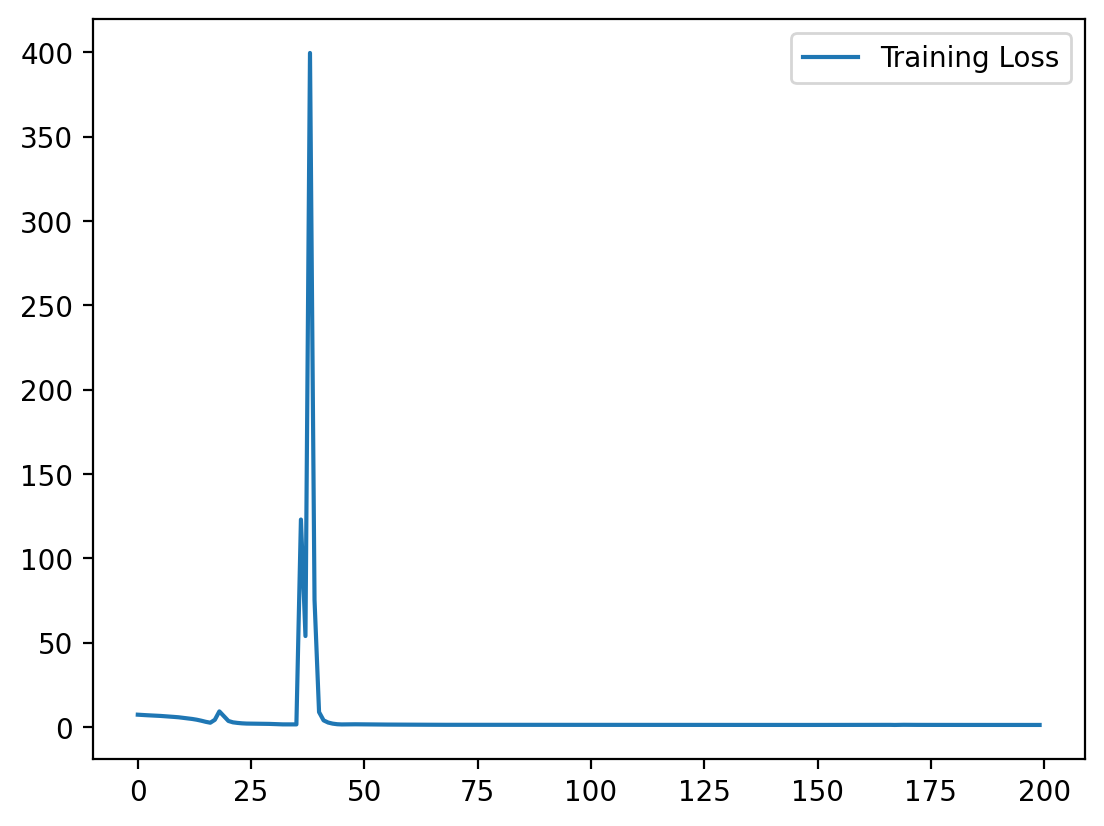

In [14]:
plt.plot(my_rnn.loss_during_training,label='Training Loss')
plt.legend()

> **Exercise:** Compute the following plot, in which we plot one of the input signals, the target one, and the prediction (mean $\pm$ two stds) by the RNN from t=20 to t=70

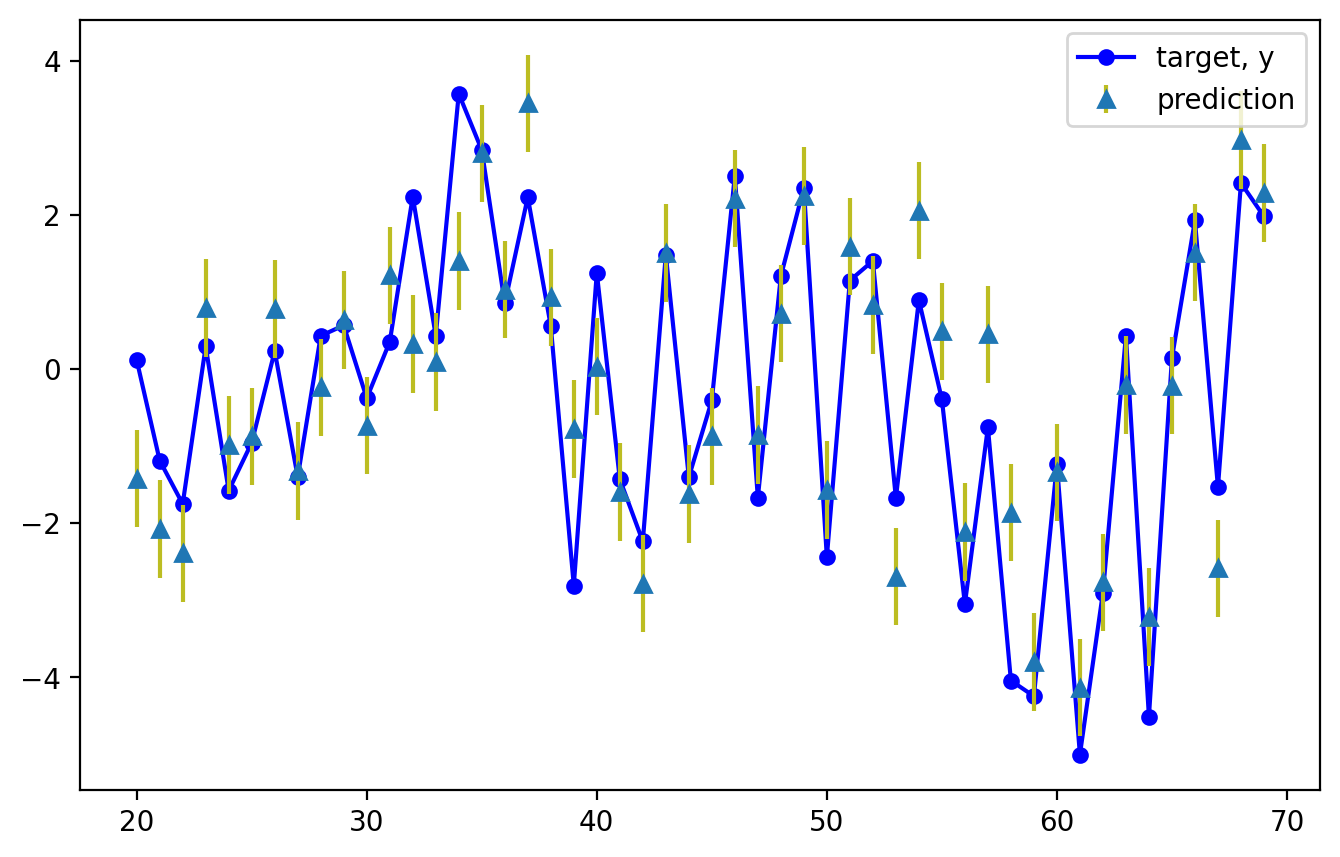

In [15]:
# We first evaluate the model for the N signals up to time T_train = 100
X_in = torch.Tensor(X[:,:T_train]).view([N,T_train,1]) # YOUR CODE HERE

mean,var,h,sample = my_rnn.forward(X_in) # YOUR CODE HERE

mean_rnn = mean.detach().numpy().reshape([N,-1])
std_rnn = np.sqrt(var.detach().numpy().reshape([N,-1]))

# Initial time point of the representation
t0 = 20

# Final point
tf = 70

signal = 10 # From 1 to N (you can play with this)

# Plot the first training signal and the target
plt.figure(figsize=(8,5))
#plt.plot(np.arange(t0,tf,1), X[signal,t0:tf], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(t0,tf,1), Y[signal,t0:tf], 'b.-', label='target, y',ms=10) # x
plt.errorbar(np.arange(t0,tf,1), mean_rnn[signal,t0:tf], 2*std_rnn[signal,t0:tf], linestyle='None', marker='^',ecolor='tab:olive',label='prediction')




plt.legend(loc='best')

Observe that the prediction is pretty good!The RNN model have clearly learnt the dynamics of the dataset. In the previous experiment, note we have fed the RNN model with the **true** values of the signal, i.e. we have used the full signal $X$ to compute the sequence of states. 

Using the model we have just trained, lets do now **forecasting**. Namely, we feed the RNN the output that we predicted and we do this recursively for as long as we want. This represents **sampling** from the probabilistic model 

$$p(X|X_0) = \prod_{t=1}^T p(X_t|\mathbf{X}_{0:t-1})$$
$$p(X_t|X_{t-1},\mathbf{X}_{0:t-2}) = \mathcal{N}\left(f_{RNN}(X_{t-1},\mathbf{h}_{t-1}),\sigma^2+g_{RNN}(X_{t-1},\mathbf{h}_{t-1})\right)$$

To do forecasting, note that we have to recursively call the `forward` method and feed the obtained RNN output and state as the entry and initial state for the next `forward` call. The following code would do the job:

Between t=0 and t=100, we feed the real values
From t=100, we feed the estimated values (forecasting)


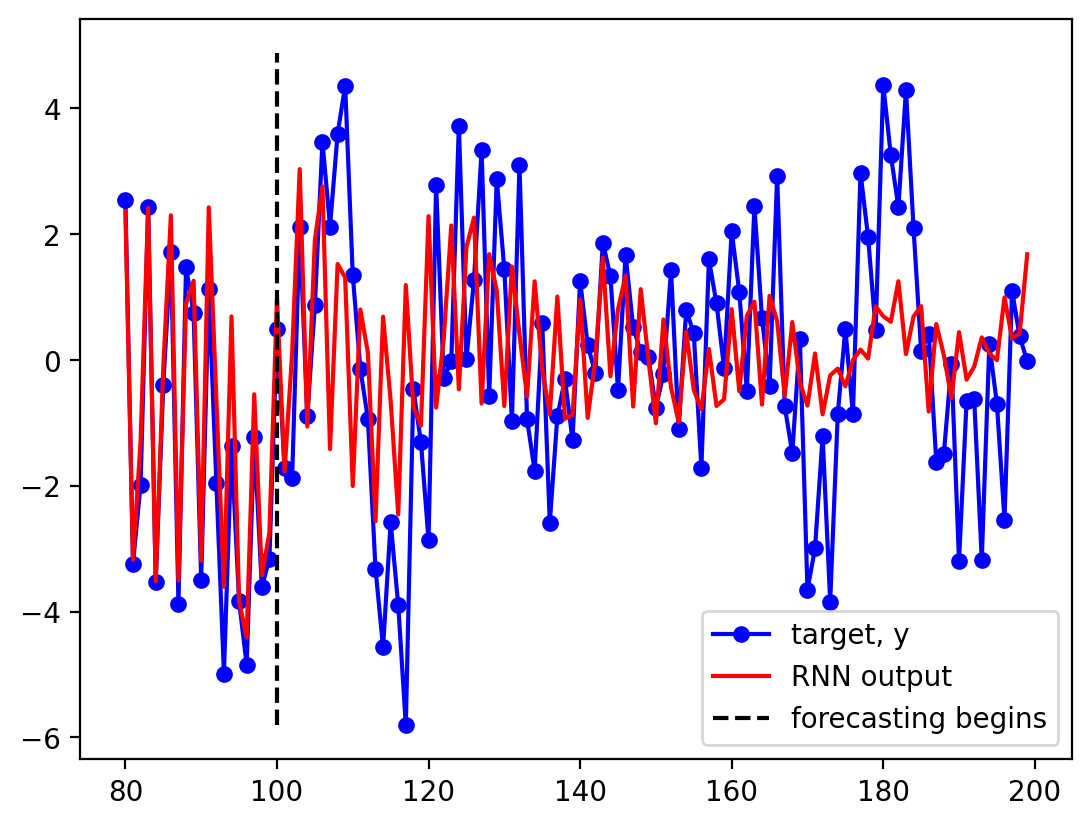

In [16]:
# We take the last output of the RNN for the N signals at time T_train
current_input = sample[:,-1,:].view([N,1,1]) 
# And the last state
current_state = h

# Here we store the sampled signals
forecast_rnn = np.zeros([N,T-T_train])

for t in range(T-T_train):
    
    # En este bucle muestreamos iterativamente el modelo
    
    mean,var,current_state,current_input = my_rnn.forward(current_input,current_state)
    
    forecast_rnn[:,t] = current_input.detach().numpy().reshape([-1,])

    
# We concatenate the original ones (until T_train) with the ones we just sampled (from T_train)    
final_rnn_reconstruct = np.hstack([mean_rnn,forecast_rnn])

# Now we plot

t0 = 80

tfinal = 200

plt.plot(np.arange(t0,tfinal,1), Y[signal,t0:tfinal].reshape([-1]), 'b.-', label='target, y',ms=10)  
plt.plot(np.arange(t0,tfinal,1), final_rnn_reconstruct[signal,t0:tfinal], 'r-', label='RNN output',ms=10) 
plt.plot([T_train,T_train],[np.min(Y[signal,:]),np.max(Y[signal,:])],'k--',label='forecasting begins')
plt.legend()

plt.legend(loc='best')
print('Between t=0 and t=100, we feed the real values')
print('From t=100, we feed the estimated values (forecasting)')

Observe that, after a while, the model deviates from the true realization. That is **expected** we are sampling from the generative model and it is likely that do not get exactly the same sample! Particularly in RNN, since they have short memory.

## LSTMs

Lets study how an LSTM would perform in this context. You can create a basic [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) as follows

```python
self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
```

where `input_size` is the number of characters this cell expects to see as sequential input, and `n_hidden` is the number of units in the hidden layers in the cell. If **stacked LSTMs (n_layers>1) are used** we can automatically add dropout between LSTM layers with te parameter `dropout` with a specified probability.

> **Exercise:** Complete the code for the following two classes 

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,sigma,drop_prob):
        
        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_size = input_size

        self.output_size = output_size

        self.sigma = torch.Tensor(np.array(sigma))

        # define an RNN with specified parameters
        # batch_first=True means that the first dimension of the input will be the batch_size
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE
        self.fc2 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE

    def forward(self, x, h0=None, valid=False):
        
        '''
        About the shape of the different tensors ...:
        
        - Input signal x has shape (batch_size, seq_length, input_size)
        - The initialization of the LSTM hidden state is a tuple, containing two tensors of dimensions
          (n_layers, batch_size, hidden_dim) each. The first tensor represents the LSTM hidden state 
          cell states. We can use the None value so internally they are initialized with 0s.
        - The LSTM output shape is (batch_size, seq_length, hidden_size) 

        '''
        
        if(valid):
            self.eval()
        else:
            self.train()
        
        batch_size = x.size(0) # Number of signals N
        seq_length = x.size(1) # T
        
        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state (we will use it for forecasting)
    
        r_out, hidden = self.lstm(x, h0)
        
        # shape r_out to be (seq_length, hidden_dim) #UNDERSTANDING THIS POINT IS IMPORTANT!!        
        r_out = r_out.reshape(-1, self.hidden_dim) 
        
        output = self.fc1(r_out)

        mean = self.fc1(r_out)
        
        variance = torch.exp(self.fc2(r_out))+torch.ones(mean.shape)*self.sigma

        # We generate noise of the adecuate variance
        noise = torch.randn_like(mean)*torch.sqrt(variance)
        
        sample = mean+noise
        
        # reshape back to temporal structure
        sample = sample.reshape([-1,seq_length,int(self.output_size)])
        mean = mean.reshape([-1,seq_length,int(self.output_size)])
        variance = variance.reshape([-1,seq_length,int(self.output_size)])
        
        return mean, variance, hidden, sample


In [18]:
class LSTM_extended(LSTM):
    
    #Your code here
    
    def __init__(self, num_data_train, num_iter, sequence_length,
                 input_size, output_size, hidden_dim, n_layers, sigma, drop_prob=0.3, lr=0.001):
        
        super().__init__(input_size, output_size, hidden_dim, n_layers,sigma,drop_prob) 
        
        self.hidden_dim = hidden_dim
        
        self.sequence_length = sequence_length
        
        self.num_layers = n_layers
        
        self.lr = lr #Learning Rate
        
        self.num_train = num_data_train #Number of training signals
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.num_iter = num_iter
        
        self.criterion = nn.MSELoss()       #YOUR CODE HERE     
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
           
    def trainloop(self,x,y):
        
        # SGD Loop
        
        for e in range(int(self.num_iter)):
        
            self.optim.zero_grad() 
                
            x = torch.Tensor(x).view([self.num_train,self.sequence_length,1])  #YOUR CODE HERE 

            y = torch.Tensor(y).view([self.num_train,self.sequence_length,1])  #YOUR CODE HERE 

            mean,var,h,sample = self.forward(x) #YOUR CODE HERE 
                
            loss = self.criterion(y,sample) #YOUR CODE HERE 
            
            loss.backward()
            
            # This code helps to avoid vanishing exploiting gradients in RNNs
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
            self.optim.step()
                
            self.loss_during_training.append(loss.item())

            if(e % 50 == 0): # Every 10 iterations

                print("Iteration %d. Training loss: %f" %(e,self.loss_during_training[-1]))                

> **Exercise:** Train the LSTM model for 200 iterations using the first 100 values of each signal. Use `hidden_dim=32`, `n_layers=1` and `sigma=0.1`. Recall that the target signal is stored in the variable `Y`.
Note that with only one layer, the dropout probability parameter does not play any role (you will get a warning actually).


In [19]:
my_lstm = LSTM_extended(num_data_train=X.shape[0],num_iter=200,sequence_length=T_train,
                     input_size=1,output_size=1,hidden_dim=32,n_layers=1,sigma=0.1,lr=0.005)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [20]:
my_lstm.trainloop(X[:,:T_train],Y[:,:T_train]) #YOUR CODE HERE

Iteration 0. Training loss: 7.194992
Iteration 50. Training loss: 2.474950
Iteration 100. Training loss: 1.275551
Iteration 150. Training loss: 1.232112


> **Exercise:** Plot the loss function along training


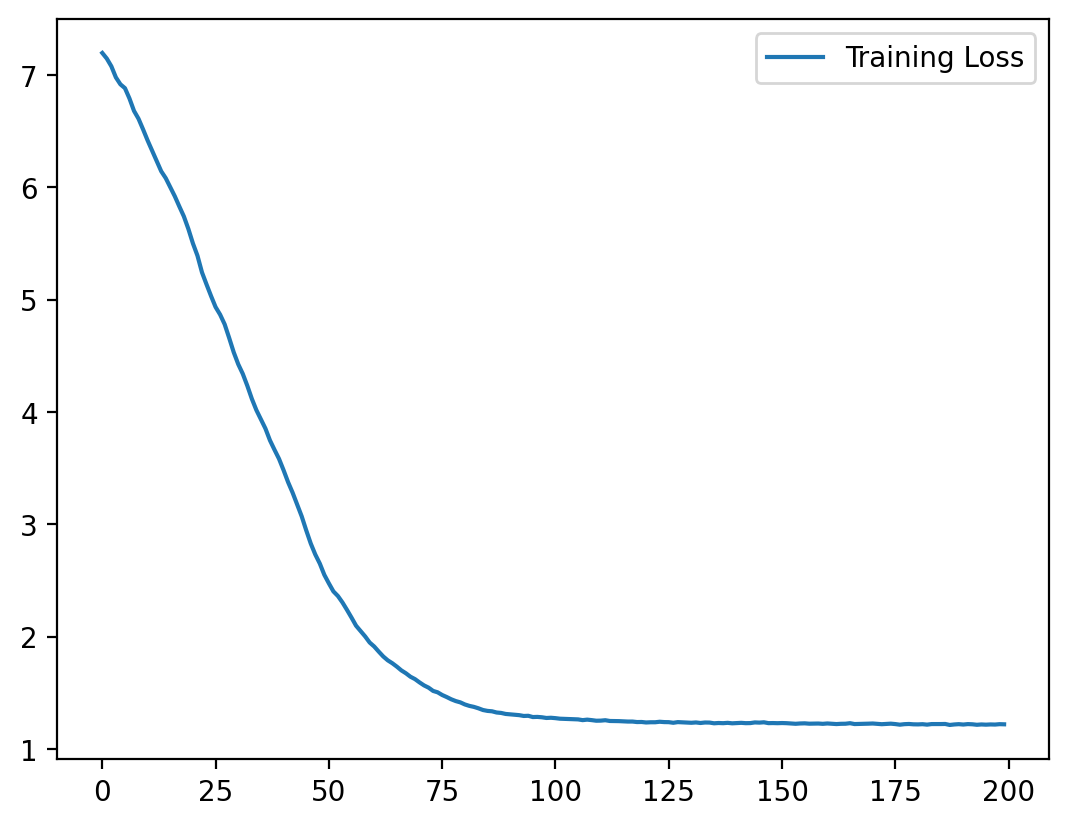

In [21]:
plt.plot(my_lstm.loss_during_training,label='Training Loss')
plt.legend()

We can see how the cost function (MSELoss) is similar in both cases. In terms of predicting the next instant with *teaching forcing*, both models achieve similar performance. Keep in mind that the memory of the autoregressive model that we have used to generate the signals is small...


> **Exercise:** Complete the code to visualize the LSTM prediction of the next value of the signal

<ErrorbarContainer object of 3 artists>

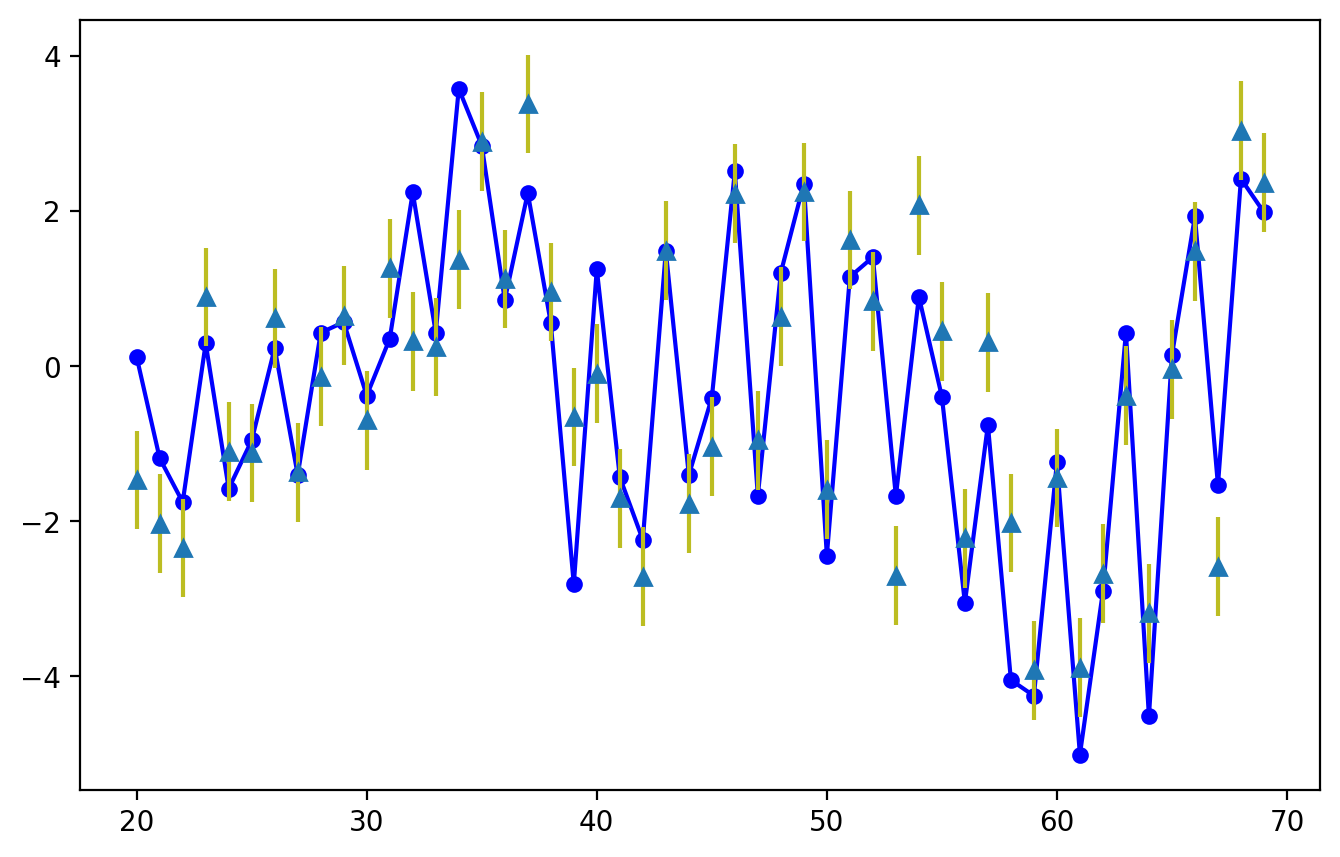

In [22]:
# We first evaluate the model for the N signals up to time T_train = 100
X_in = torch.Tensor(X[:,:T_train]).view([N,T_train,1]) 

mean,var,h,sample = my_lstm.forward(X_in) #

mean_lstm = mean.detach().numpy().reshape([N,-1])
std_lstm = np.sqrt(var.detach().numpy().reshape([N,-1]))

# Initial time point of the representation
t0 = 20

# Final point
tf = 70

signal = 10 # From 1 to N (you can play with this)

# Plot the first training signal and the target
plt.figure(figsize=(8,5))
#plt.plot(np.arange(t0,tf,1), X[signal,t0:tf], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(t0,tf,1), Y[signal,t0:tf], 'b.-', label='target, y',ms=10) # x
plt.errorbar(np.arange(t0,tf,1), mean_lstm[signal,t0:tf], 2*std_lstm[signal,t0:tf], linestyle='None', marker='^',ecolor='tab:olive',label='prediction')



> **Exercise:** Complete the code to visualize the LSTM forecasting. Plot the LSTM vs RNN vs target for a few signals and discuss the results.

Between t=0 and t=100, we feed the real values
From t=100, we feed the estimated values (forecasting)


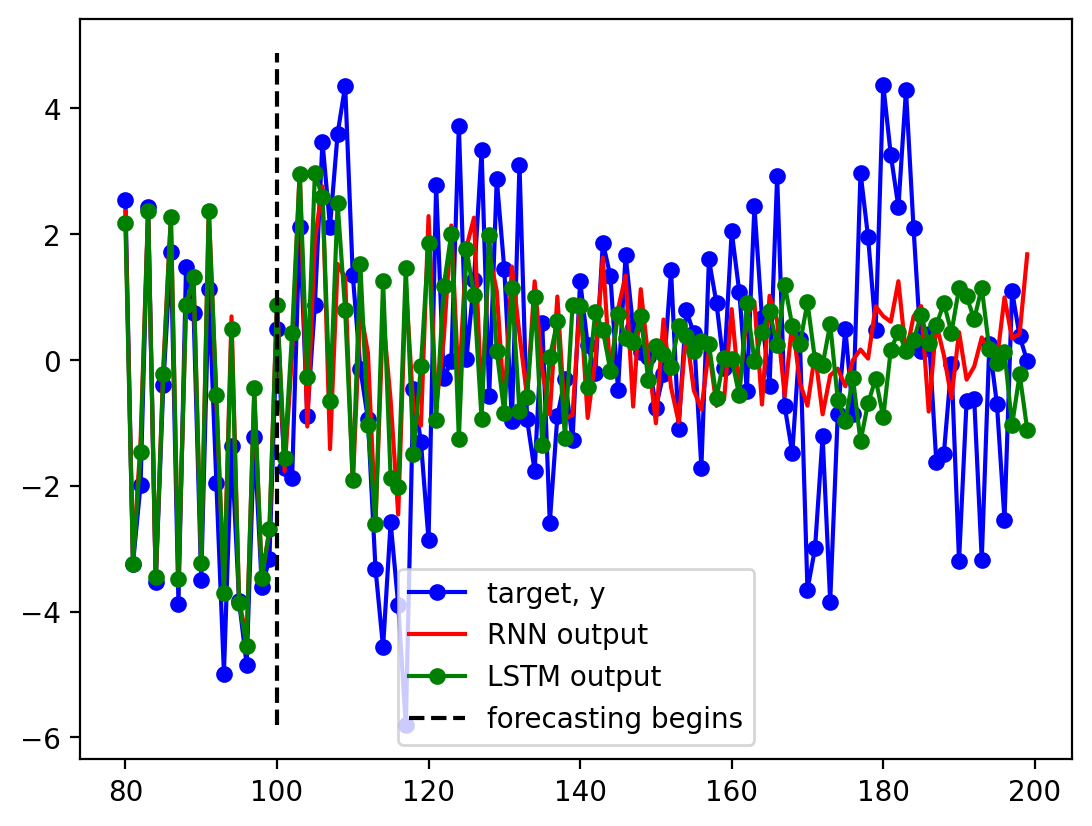

In [23]:
# We take the last RNN output 
current_input = sample[:,-1,:].view([N,1,1]) #Note that current input only contains one observation for each of the N signals
# We take the last RNN state
current_state = h

forecast_lstm = np.zeros([N,T-T_train])

for t in range(T-T_train):
    
    # ... and feed them as input and initial state
    
    mean,var,current_state,current_input = my_lstm.forward(current_input,current_state)  # YOUR CODE HERE
    
    forecast_lstm[:,t] = current_input.detach().numpy().reshape([-1,])
    
final_lstm_reconstruct = np.hstack([mean_lstm,forecast_lstm])

# We plot the signal and the target before and after forecasting

signal = 10

t0 = 80

tfinal = 200

plt.plot(np.arange(t0,tfinal,1), Y[signal,t0:tfinal].reshape([-1]), 'b.-', label='target, y',ms=10)  
plt.plot(np.arange(t0,tfinal,1), final_rnn_reconstruct[signal,t0:tfinal], 'r-', label='RNN output',ms=10) 
plt.plot(np.arange(t0,tfinal,1), final_lstm_reconstruct[signal,t0:tfinal], 'g.-', label='LSTM output',ms=10) 
plt.plot([T_train,T_train],[np.min(Y[signal,:]),np.max(Y[signal,:])],'k--',label='forecasting begins')
plt.legend()


print('Between t=0 and t=100, we feed the real values')
print('From t=100, we feed the estimated values (forecasting)')

The conclusions are similar, since both models have captured well the dynamics of the data, generated with an autoregressive model with reduced memory. It seems LSTMs does better though.